# Spam Classifier

### Data pre-processing
The first step in every machine learning algorithm is to process the raw data in some meaningful representations. We will be using the Bag-of-Words representation to process the text. It comprises of following steps:

- Process emails line-by-line to extract all the words.
- Replace extracted words by their stem (root) word. This is known as stemming and lematization.
- Remove stop words like and, or, is, am, and so on.
- Assign a unique index to each word. This forms the vocabulary.
- Represent each email as a binary vector of length equal to the size of the vocabulary such that the $i^{th}$ element of the vector is 1 iff the $i^th$ word is present in the email.


In [1]:
import numpy as np
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pandas as pd


# takes an email as an argument
# read email line-by-line and extract all the words
# return list of extracted words
def read_email(data):
    data['processed_data'] = data['email'].apply(word_tokenize)
#     data["processed_data"]=data["email"].apply(lambda x:[x.split()])
    data['processed_data'] = data['processed_data'].apply(lambda x: [word.lower() for word in x])
    return data
  
# takes a list of words as an argument
# replace each word by their stem word
# return list of stem words
def stemming(data):
    data["processed_data"] = data["processed_data"].apply(lambda x: [PorterStemmer().stem(w) for w in x])
    return data

# takes a list of stem-words as an argument
# remove stop words
# return list of stem words after removing stop words
def remove_stop_words(data):
    stop_words=stopwords.words("english")
    data["processed_data"]=data["processed_data"].apply(lambda x:[word for word in x if word not in stop_words])
    return data

# takes a list of stem-words as an argument
# add new words to the vocabulary and assign a unique index to them
# returns new vocabulary
def build_vocabulary(data):
    vocabulary=[]
    for i in data["processed_data"]:
        vocabulary=vocabulary+i
    vocabulary=set(vocabulary)
    vocabulary = dict.fromkeys(vocabulary, 0)

    i=0
    for key in vocabulary.keys():
        vocabulary[key] = i
        i+=1
    vocabulary
    return vocabulary

# takes a list of stem-words and vocabulary as an argument
# returns bow representation
def get_bow(data,vocabulary):
    from keras.preprocessing.text import Tokenizer
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(data["processed_data"])
    email_bow = tokenizer.texts_to_matrix(data["processed_data"], mode='binary')
    return email_bow

# read the entire dataset
# convert emails to bow and maintain their labels
# call function text_to_bow()
def read_data():
    with open('spam_or_not_spam.csv') as f:
        data = pd.read_csv(f)
        f.close()
        for i in range(len(data)):
            if type(data["email"][i])!=str:
                data.drop(i,axis=0,inplace=True)
    return data

In [2]:
data=read_data()
data=read_email(data)
data=stemming(data)
data=remove_stop_words(data)
vocabulary=build_vocabulary(data)
bow=get_bow(data,vocabulary)

2022-04-22 19:01:21.593975: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-22 19:01:21.593999: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


### Data Visualization
Let's understand the data distribution
- Visualize the frequency of word-occurence in all the emails(spam + non-spam)
- Visualize the freuency of word-occurence for spam and non-spam emails separately

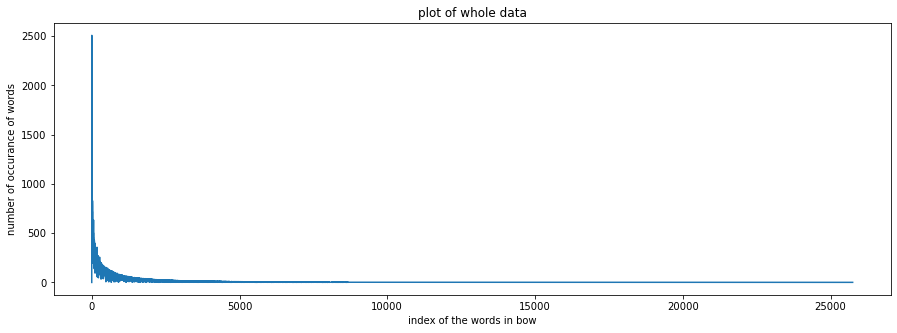

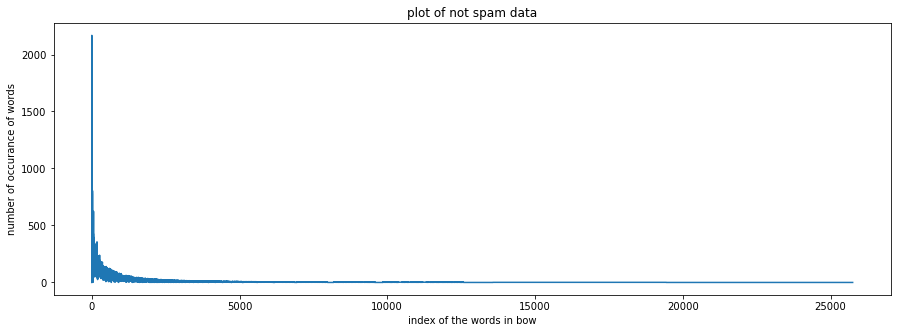

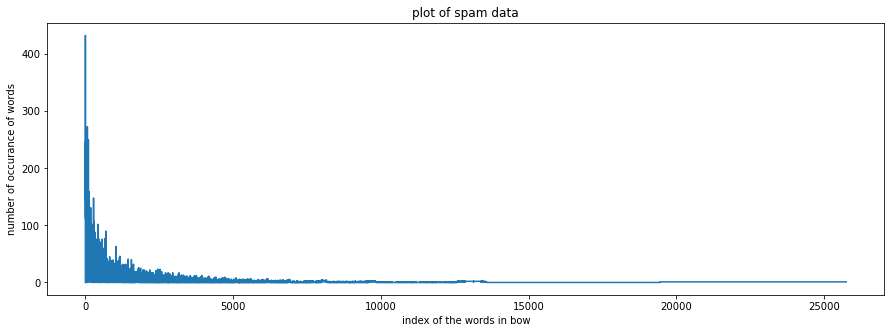

In [3]:
import matplotlib.pyplot as plt

# visuallze data distribution
def data_vis(bow):
    bow_not_spam=[]
    for i in range(2500):
        bow_not_spam.append(bow[i])
    bow_not_spam=np.array(bow_not_spam)
    bow_spam=[]
    for i in range(2501,len(bow)):
        bow_spam.append(bow[i])
    bow_spam=np.array(bow_spam)    
    
    y1=np.sum(bow,axis=0)
    x1=np.arange(len(y1))
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(5)
    plt.plot(x1,y1)
    plt.xlabel("index of the words in bow")
    plt.ylabel("number of occurance of words")
    plt.title("plot of whole data")
    plt.show()

    y2=np.sum(bow_not_spam,axis=0)
    x2=np.arange(len(y2))
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(5)
    plt.plot(x2,y2)
    plt.xlabel("index of the words in bow")
    plt.ylabel("number of occurance of words")
    plt.title("plot of not spam data")
    plt.show()

    y3=np.sum(bow_spam,axis=0)
    x3=np.arange(len(y3))
    f = plt.figure()
    f.set_figwidth(15)
    f.set_figheight(5)
    plt.plot(x3,y3)
    plt.xlabel("index of the words in bow")
    plt.ylabel("number of occurance of words")
    plt.title("plot of spam data")
    plt.show()
    return

data_vis(bow)

### Learn a Classifier
Split the dataset randomly in the ratio 80:20 as the training and test dataset. Use only training dataset to learn the classifier. No test data should be used during training. Test data will only be used during evaluation.

Now let us try to use ML algorithms to classify emails as spam or non-spam. You are supposed to implement SVM and K-Nearest Neighbour algorithm available in scikit-learn using the same training dataset for both.

In [20]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn import metrics
# split dataset
def split(bow,data):
    X,Y = bow,data["label"].to_numpy()
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    return X_train, Y_train, X_test, Y_test

# learn a SVM model
# use the model to make prediction
# return the model predictions on train and test dataset
def svm_classifier(X_train,X_test,Y_train,Y_test):
    SupportVectorClassModel = svm.SVC() 
    SupportVectorClassModel.fit(X_train,Y_train)
    predict_svm_test = SupportVectorClassModel.predict(X_test)
    predict_svm_train = SupportVectorClassModel.predict(X_train)
    return predict_svm_train,predict_svm_test

# implement k-NN algorithm
# use the model to make prediction
# return the model predictions on train and test dataset
def knn_classifier(X_train,X_test,Y_train,Y_test):
    max_accuracy=0
    max_accuracy_neighbours=1
    for i in range(1,20):
        knn = KNeighborsClassifier(n_neighbors=i)
        knn.fit(X_train, Y_train)
        pred = knn.predict(X_test)
        accuracy=metrics.accuracy_score(Y_test, pred)*100
        if(accuracy>max_accuracy):
            max_accuracy=accuracy
            max_accuracy_neighbours=i

    knn = KNeighborsClassifier(n_neighbors=max_accuracy_neighbours)
    knn.fit(X_train, Y_train)
    predict_knn_train = knn.predict(X_train)
    predict_knn_test = knn.predict(X_test)
    return predict_knn_train, predict_knn_test

X_train, Y_train, X_test, Y_test = split(bow,data)
svm_train_predictions, svm_test_predictions = svm_classifier(X_train,X_test,Y_train,Y_test)

knn_train_predictions, knn_test_predictions = knn_classifier(X_train,X_test,Y_train,Y_test)
print(knn_train_predictions)
print()
print(knn_test_predictions)
print()
print(svm_train_predictions)
print()
print(svm_test_predictions)

[0 0 0 ... 0 0 0]

[0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1
 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 1 1 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 0 1 0 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0
 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 1 1

### Model Evaluation
Compare the SVM and k-NN model using metrics
- Accuracy
- [AUC score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html)


In [32]:
# compute accuracy 
def compute_accuracy(Y_test, pred):
    accuracy=metrics.accuracy_score(Y_test, pred)*100
    return accuracy

# compute AUC score 
def compute_auc(Y_test, test_predictions):
    print(pd.DataFrame(metrics.confusion_matrix(Y_test, test_predictions),
             columns=['Predicted not spam', "Predicted spam"], index=['Actual not spam', 'Actual spam']))
    true_spam, false_spam, false_not_spam, true_not_spam = metrics.confusion_matrix(Y_test, test_predictions).ravel()
    print()
    print()
    print('True Spam : ',true_spam)
    print('False Spam: ',false_spam)
    print('True Not Spam: ',true_not_spam)
    print('False Not Spam: ',false_not_spam)

    return 

# write code to print train and test accuracy and AUC score of SVM and k-NN classifier
svm_accuracy=compute_accuracy(Y_test,svm_test_predictions)
print("svm accuracy : ",svm_accuracy)
knn_accuracy=compute_accuracy(Y_test,knn_test_predictions)
print("knn accuracy : ",knn_accuracy)
print()
print("For svm : ")
svm_auc=compute_auc(Y_test,svm_test_predictions)
print("For svm : ")
print()
print("For knn : ")
svm_auc=compute_auc(Y_test,knn_test_predictions)


svm accuracy :  97.5
knn accuracy :  93.66666666666667

For svm : 
                 Predicted not spam  Predicted spam
Actual not spam                 500               0
Actual spam                      15              85


True Spam :  500
False Spam:  0
True Not Spam:  85
False Not Spam:  15
For svm : 

For knn : 
                 Predicted not spam  Predicted spam
Actual not spam                 492               8
Actual spam                      30              70


True Spam :  492
False Spam:  8
True Not Spam:  70
False Not Spam:  30
